# Load data

In [346]:
import os 
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt
import csv 
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams["figure.figsize"] = (8,6)

In [171]:
# df = pd.read_csv('data/台電DATA.csv', parse_dates=['日期'], index_col=['日期'])

In [172]:
# new = pd.read_csv('data/2020備載.csv', parse_dates=['日期'], index_col=['日期'])

In [173]:
# old = pd.read_csv('data/2014長期備載.csv', parse_dates=['日期'], index_col=['日期'])

In [174]:
# newest = pd.read_csv('data/new.csv', parse_dates=['日期'], index_col=['日期'])

## 天氣預測

In [349]:
with open('data/預報3.json', 'r', encoding='UTF-8') as f:
    forcast = json.load(f)

In [350]:
forcast_list = forcast['cwbdata']['resources']['resource']['data']['agrWeatherForecasts']['weatherForecasts']['location']

In [351]:
data_list = []
for loc_forcast in forcast_list:
    for date_temp in loc_forcast['weatherElements']['MaxT']['daily']:
        data_list.append([date_temp['dataDate'], float(date_temp['temperature'])])
    for date_temp in loc_forcast['weatherElements']['MinT']['daily']:
        data_list.append([date_temp['dataDate'], float(date_temp['temperature'])])

In [352]:
forcast_df = pd.DataFrame(data_list, columns=['日期', '溫度'])

In [353]:
forcast_temp = forcast_df.groupby(['日期'])['溫度'].mean()

In [355]:
forcast_temp

日期
2021-03-23    18.500000
2021-03-24    20.750000
2021-03-25    21.416667
2021-03-26    22.500000
2021-03-27    23.166667
2021-03-28    24.750000
2021-03-29    25.333333
Name: 溫度, dtype: float64

## 月平均溫度

In [356]:
# temp = pd.read_csv('data/平均氣溫.csv', encoding='big5')

In [357]:
# temp['year'] = temp['臺灣地區平均氣溫'].apply(lambda x: int(x.split(' ')[0].split('年')[0]))
# temp['month'] = temp['臺灣地區平均氣溫'].apply(lambda x: int(x.split(' ')[1].split('月')[0]))
# temp['avg'] = temp[['臺北(℃)', '高雄(℃)', '淡水(℃)', '新竹(℃)', '臺中(℃)', '花蓮(℃)']].mean(axis= 1)
# temp = temp[temp['year'] >= 108]

## 每日觀測資料

In [358]:
drop_loc = ['鞍部', '淡水', '東吉島', '竹子湖', '阿里山', '大武', '成功', '蘭嶼', '梧棲', '日月潭', '金門', '馬祖', '彭佳嶼', '玉山', '新屋']

In [359]:
def record_generator(file_name):
    with open(f'data/daily_data/{file_name}', 'r') as f: 
        data = [line.strip() for line in f.readlines()]
        record = [np.array(data[i*24].split(','))[[2,3,-1]] for i in range(int(len(data)/24))]
        record_df = pd.DataFrame(record, columns=['loc', 'date', 'temp'])
        record_df.drop((record_df[record_df['temp']=='X'].index), inplace= True)
        record_df.drop(record_df[record_df['loc'].isin(drop_loc)].index, inplace= True)
        
        try:
            record_df['temp'] = record_df['temp'].astype(float)
        except:
            drop_idx = []
            for i, row in record_df.iterrows():
                try:
                    float(row['temp'])
                except:
                    drop_idx.append(i)
            record_df.drop(drop_idx, inplace= True)
            record_df['temp'] = record_df['temp'].astype(float)
            
    return record_df

In [360]:
# record_df.groupby(['date'])['temp'].mean()

In [361]:
all_files = os.listdir("data/daily_data/")

In [362]:
for i, file in enumerate(all_files):
    record_generator(file)
print('done')

done


In [363]:
all_record = pd.concat([record_generator(file) for file in all_files], axis= 0)

In [364]:
all_record.drop_duplicates(inplace=True)

In [365]:
all_record['date'] = all_record['date'].apply(lambda x: x.split(' ')[0])
all_record['date'] = all_record['date'].apply(lambda x: datetime.strptime(x, '%Y/%m/%d'))

In [366]:
all_record['loc'].unique()

array(['臺北', '基隆', '花蓮', '蘇澳', '宜蘭', '澎湖', '臺南', '高雄', '嘉義', '臺中', '新竹',
       '恆春', '臺東', '板橋'], dtype=object)

## 結合Y

In [367]:
# y = df['備轉容量(MW)']

In [368]:
# y = pd.concat([old['2019':]['備轉容量(萬瓩)']*10, new[:]['備轉容量(萬瓩)']*10, newest[:]['備轉容量(萬瓩)']*10], axis= 0)

In [369]:
y = pd.read_csv('data/training_data.csv', encoding='big5', parse_dates=['日期'], index_col=['日期'])

In [370]:
y = y['備載容量']

In [371]:
y.head(3)

日期
2019-01-01    2557.0
2019-01-02    1900.0
2019-01-03    1892.0
Name: 備載容量, dtype: float64

In [372]:
dates = y.index
print(f'newest date: {dates[-1]}')

newest date: 2021-03-21 00:00:00


In [373]:
# import csv

In [374]:
# with open('data/training_data.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['日期', '備載容量'])
#     for i, row in pd.DataFrame(y).iterrows():
#         writer.writerow([row.name, row[0]])

# EDA

## 月均備載 vs 月均溫
**顯著相關**

In [375]:
# avg_y = y.resample('1M').mean()
# temp['date'] = y.resample('1M').mean().index[:-2]
# temp.set_index('date', inplace= True)
# avg_temp = temp['avg']
# plt.plot((avg_temp-min(avg_temp))/(max(avg_temp)-min(avg_temp)), label= 'average monthly temp')
# plt.plot((avg_y-min(avg_y))/(max(avg_y)-min(avg_y)), label= 'average monthly Operating Reserve')
# plt.legend()
# plt.show()

## 日備載

In [376]:
grouped_df = all_record.groupby(['date'])['temp'].mean()
grouped_normalized = (grouped_df - min(grouped_df))/(max(grouped_df)-min(grouped_df))

In [377]:
y_normalized = (y['2019':] - min(y['2019':])) / (max(y['2019':])-min(y['2019':]))

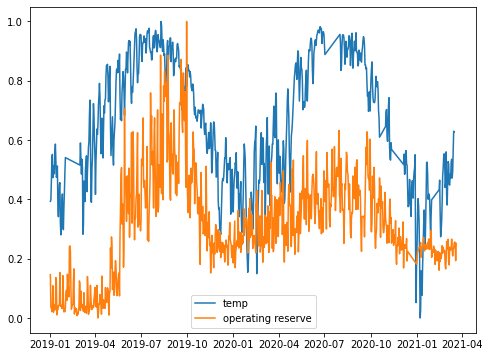

In [378]:
plt.plot(grouped_normalized, label= 'temp')
plt.plot(y_normalized, label= 'operating reserve')
plt.legend()
plt.show()

### 日備載與日溫相關性

In [379]:
y['2019':].corr(grouped_df)

0.4906476545208392

## 周間備轉容量

In [380]:
new_df = pd.DataFrame(y)
weekday = [ day.weekday() for day in new_df.index ]
new_df['weekday'] = weekday
print(f'data len: {len(new_df)}')
new_df.tail(5)

data len: 795


,備載容量,weekday
日期,,
2021-03-17,3183.0,2
2021-03-18,3214.0,3
2021-03-19,3137.0,4
2021-03-20,2839.0,5
2021-03-21,3186.0,6


In [381]:
# plt.plot(new_df.groupby(['weekday'])['備轉容量(萬瓩)'].mean())
# plt.title('Operating Reserve weekly')

In [382]:
# df.corr().iloc[:, 2].sort_values(ascending=False).iloc[:10, ]

# Regression Model

In [383]:
from sklearn.linear_model import LinearRegression

In [384]:
shared_dates = np.intersect1d(grouped_normalized.index, y_normalized.index)

In [385]:
# idx = pd.date_range('2019-01-01', '2021-03-15')
# grouped_normalized = grouped_normalized.reindex(idx, method= 'ffill')
# y_normalized = y_normalized.reindex(idx, method= 'ffill')

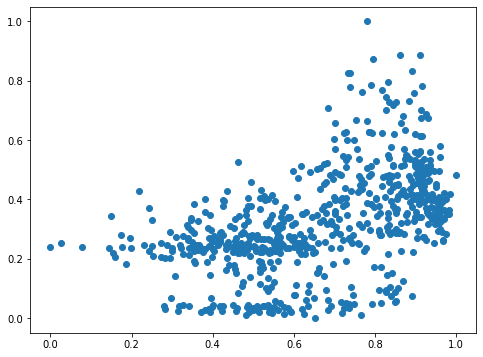

In [386]:
plt.scatter(grouped_normalized[shared_dates], y_normalized[shared_dates])

## fitting 

In [387]:
train_st = datetime(2019, 1, 1)
train_en = datetime(2021, 3, 7)
test_en = datetime(2021, 3, 15)

train_X = np.array(grouped_normalized[shared_dates][train_st:train_en]).reshape(-1,1)
train_y = np.array(y_normalized[shared_dates][train_st:train_en]).reshape(-1,1)
test_X = np.array(grouped_normalized[shared_dates][train_en+timedelta(days= 1):test_en]).reshape(-1,1)
test_y = np.array(y_normalized[shared_dates][train_en+timedelta(days= 1):test_en]).reshape(-1,1)

In [388]:
reg = LinearRegression().fit(train_X, train_y)

In [389]:
reg.score(train_X, train_y)

0.238607942073211

In [390]:
reg.coef_

array([[0.39690039]])

## 預測

In [391]:
y_normalized[shared_dates][train_en+timedelta(days= 1):].index

DatetimeIndex(['2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11',
               '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15',
               '2021-03-16', '2021-03-17'],
              dtype='datetime64[ns]', name='日期', freq=None)

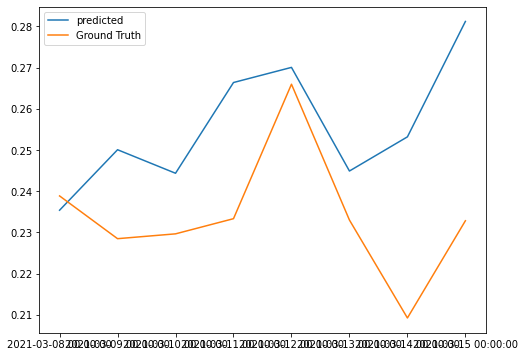

In [392]:
plt.plot(reg.predict(test_X), label= 'predicted')
plt.plot(test_y, label= 'Ground Truth')
plt.xticks(ticks= list(range(len(test_y))), labels=pd.date_range(train_en+timedelta(days= 1), '2021-03-15'))
plt.legend()
plt.show()

In [393]:
original_y_preds = reg.predict(test_X) * (max(y['2019':])-min(y['2019':])) + min(y['2019':])

# SARIMA MODEL

## 一階差分平穩

In [394]:
diff = 1

In [395]:
first_diff = y['2019':].diff(periods= diff)[diff:]

Text(0, 0.5, 'WM')

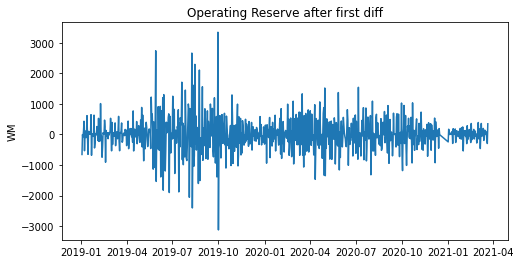

In [396]:
plt.figure(figsize=(8, 4))
plt.plot(first_diff)
plt.title('Operating Reserve after first diff')
plt.ylabel('WM')

## 平穩檢定

In [397]:
_, pvalue, *_ = adfuller(first_diff)
print(f'p value: {pvalue}')

p value: 8.213139062940487e-18


## ACF

In [398]:
# acf_vals = acf(first_diff, fft=False)
# n_lags = 40
# plt.bar(range(n_lags), acf_vals[:n_lags])

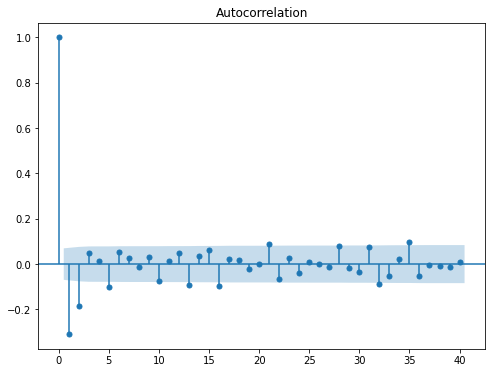

In [399]:
_ = plot_acf(x= first_diff, alpha=0.05, lags=40)

## PACF

In [400]:
# pacf_vals = pacf(first_diff)
# n_lags = 40
# plt.bar(range(n_lags), pacf_vals[:n_lags])

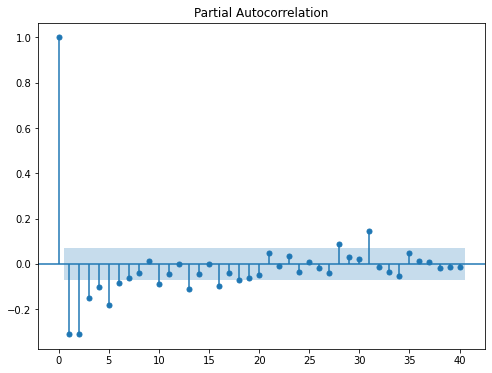

In [401]:
_ = plot_pacf(x= first_diff, alpha=0.05, lags=40)

## Fitting SARIMA
1. 設定freq
2. train test split 
3. order setting 
4. fitting model

**The Ljung–Box test may be defined as**:

H0: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
Ha: The data are not independently distributed; they exhibit serial correlation.

**The Durbin-Watson test statistic**
tests the null hypothesis that the residuals from an ordinary least-squares regression are not autocorrelated against the alternative that the residuals follow an AR1 process. The Durbin-Watson statistic ranges in value from 0 to 4.

In [402]:
y = y.asfreq(freq= pd.infer_freq(y.index))

In [403]:
train_data = y[train_st:train_en]
test_data = y[train_en + timedelta(days= 1):test_en]

In [404]:
'''order = (5,1,2), seasonal_order = (0, 1, 1, 7) best feature'''
order = (4,1,2)
seasonal_order = (0, 1, 1, 7)
model = SARIMAX(train_data, order= order, seasonal_order= seasonal_order)

In [405]:
'''FIT THE MODEL'''
model_fit = model.fit()

D:\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\python\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [406]:
print(model_fit.summary())

                                 Statespace Model Results                                
Dep. Variable:                              備載容量   No. Observations:                  797
Model:             SARIMAX(4, 1, 2)x(0, 1, 1, 7)   Log Likelihood               -5909.634
Date:                           Mon, 22 Mar 2021   AIC                          11835.268
Time:                                   17:31:46   BIC                          11872.634
Sample:                               01-01-2019   HQIC                         11849.632
                                    - 03-07-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4827      0.026    -18.750      0.000      -0.533      -0.432
ar.L2          0.5789      0.030     19.573

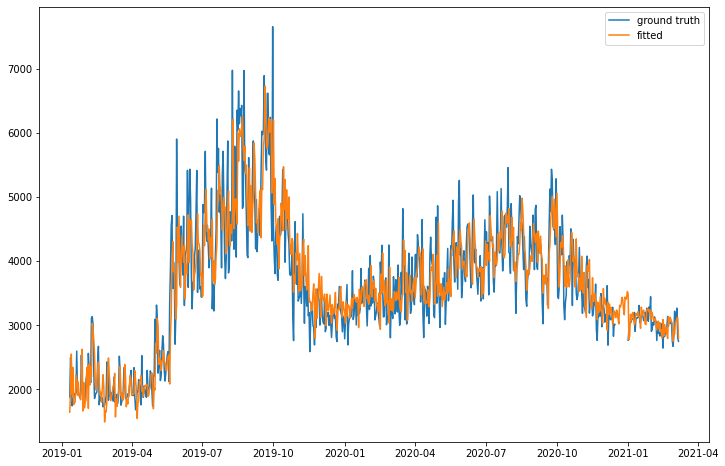

In [407]:
fig = plt.figure(figsize= (12,8))
plt.plot(train_data[10:], label= 'ground truth')
plt.plot(model_fit.fittedvalues[10:], label= 'fitted')
plt.legend()

## Residuals 

### Training res

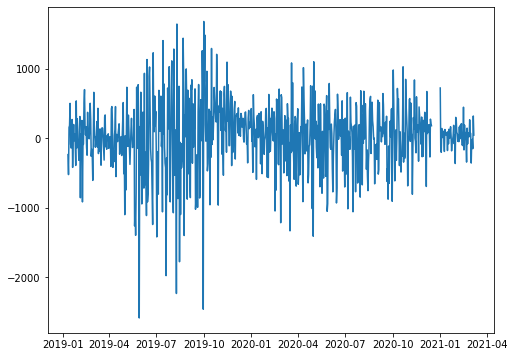

In [408]:
res = model_fit.fittedvalues[10:] - train_data[10:]
plt.plot(res)

### Testing 

In [409]:
preds = model_fit.forecast(len(test_data))
preds = pd.Series(preds, index= test_data.index)
residuals = test_data - preds

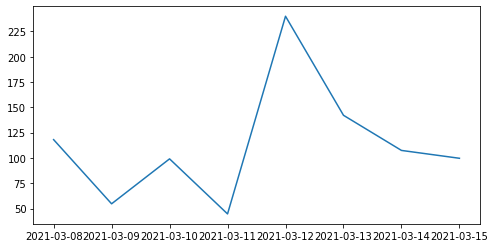

In [410]:
plt.figure(figsize= (8,4))
plt.plot(residuals)

## Predictions

Text(0, 0.5, 'WM')

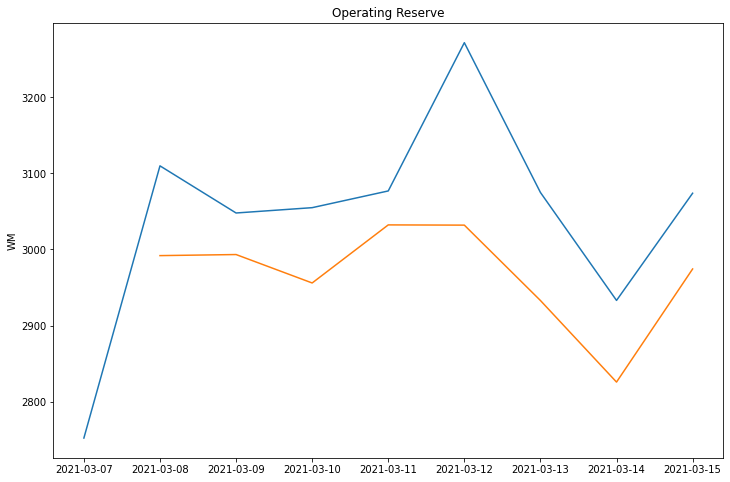

In [411]:
plt.figure(figsize=(12, 8))
plt.plot(y[train_en:test_en], label= 'Ground Truth')
plt.plot(preds, label= 'Prediction')
plt.title('Operating Reserve')
plt.ylabel('WM')

## MSE

### pure SARIMA

In [412]:
rmse = np.sqrt((residuals**2).mean())
print(f'mse: {round(rmse,2)}')

mse: 126.48


### Hybrid

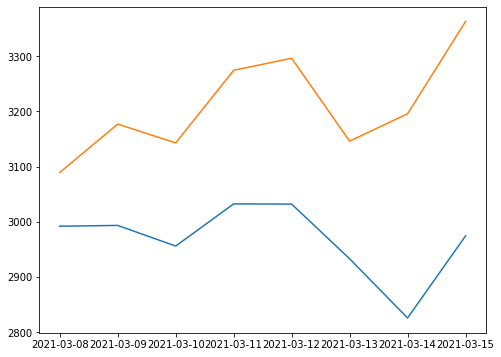

In [413]:
reg_pred = pd.Series(data= [x[0] for x in original_y_preds.tolist()], index= y_normalized[train_en + timedelta(days= 1):test_en].index)
sarima_pred = preds 
plt.plot(sarima_pred)
plt.plot(reg_pred)
plt.show()

In [414]:
hybrid_pred = 0.5*reg_pred + 0.5*sarima_pred

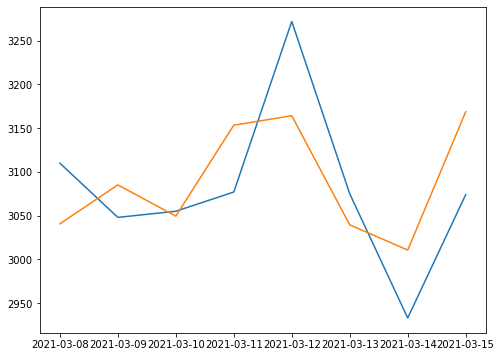

In [415]:
plt.plot(test_data)
plt.plot(hybrid_pred)

## Hybrid RMSE

In [416]:
hybrid_residuals = hybrid_pred - test_data
hybrid_rmse = np.sqrt((hybrid_residuals**2).mean())
print(hybrid_rmse)

70.65559938855073


# Submission CSV

## Temp

In [417]:
forcast_temp

日期
2021-03-23    18.500000
2021-03-24    20.750000
2021-03-25    21.416667
2021-03-26    22.500000
2021-03-27    23.166667
2021-03-28    24.750000
2021-03-29    25.333333
Name: 溫度, dtype: float64

In [418]:
temp_X = ((forcast_temp - min(grouped_df))/(max(grouped_df)-min(grouped_df))).values.reshape(-1, 1)

In [419]:
pred_y = (reg.predict(temp_X)*(max(y['2019':])-min(y['2019':])) + min(y['2019':])).reshape(1, -1)[0]

In [420]:
pred_y = pd.Series(data= pred_y, index= forcast_temp.index)

In [421]:
pred_y

日期
2021-03-23    2976.358571
2021-03-24    3232.230832
2021-03-25    3308.044836
2021-03-26    3431.242591
2021-03-27    3507.056595
2021-03-28    3687.114852
2021-03-29    3753.452105
dtype: float64

## SARIMA

In [422]:
train_en = datetime(2021, 3, 21)
train_data = y['2019':train_en]
order = (4,1,2)
seasonal_order = (0, 1, 1, 7)
SARIMA_model = SARIMAX(train_data, order= order, seasonal_order= seasonal_order)
SARIMA_model_fit = SARIMA_model.fit()

D:\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [423]:
forcast_y = SARIMA_model_fit.forecast(8)[1:]

In [424]:
forcast_y

2021-03-23    3133.842943
2021-03-24    3130.325373
2021-03-25    3174.806389
2021-03-26    3136.108708
2021-03-27    3011.569250
2021-03-28    2911.124920
2021-03-29    3102.747934
Freq: D, dtype: float64

## Combine

In [425]:
hybrid = 0.5*pred_y.values + 0.5*forcast_y.values

In [426]:
hybrid

array([3055.1007571 , 3181.27810255, 3241.42561262, 3283.67564963,
       3259.31292212, 3299.11988622, 3428.10001966])

## Output 

In [427]:
data = {'dates':['20210323', '20210324', '20210325', '20210326','20210327', '20210328', '20210329'],
       'operating_reserve(MW)': hybrid}
pd.DataFrame(data)

,dates,operating_reserve(MW)
0,20210323,3055.100757
1,20210324,3181.278103
2,20210325,3241.425613
3,20210326,3283.675650
4,20210327,3259.312922
5,20210328,3299.119886
6,20210329,3428.100020


In [428]:
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['date', 'operating_reserve(MW)'])
    for i in range(7):
        writer.writerow([data['dates'][i], data['operating_reserve(MW)'][i]])